In [44]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from pandas.plotting import lag_plot
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

import yfinance as yf

In [45]:
start_date = datetime(2021,1,1)
end_date = datetime(2022,1,1)
NVR = yf.download('NVR',start_date ,end_date)
Y = NVR['Adj Close'].values
NVR["Date"] = NVR.index
NVR = NVR[["Date", "Open", "High", 
             "Low", "Close", "Adj Close", "Volume"]]
NVR.reset_index(drop=True, inplace=True)
print(NVR.head())


[*********************100%***********************]  1 of 1 completed
        Date         Open         High          Low        Close    Adj Close  \
0 2021-01-04  4089.979980  4106.790039  3988.000000  4040.649902  4040.649902   
1 2021-01-05  4025.199951  4049.989990  3965.000000  4008.909912  4008.909912   
2 2021-01-06  3970.000000  4021.489990  3892.000000  3966.489990  3966.489990   
3 2021-01-07  3997.479980  4080.729980  3977.030029  4025.929932  4025.929932   
4 2021-01-08  4040.689941  4077.000000  3892.669922  3930.000000  3930.000000   

   Volume  
0   23700  
1   26800  
2   29400  
3   29600  
4   44600  


In [46]:
def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = param0[0]
    T = param0[1]
    H = param0[2]
    Q = param0[3]
    # "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            Likelihood = np.sum(KF_Dens[1:-1])  
            return Likelihood

In [47]:
def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            # "Please fill this part."
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    
            u_smooth = np.zeros(S)
            P_smooth = np.zeros(S)
            u_smooth[S-1] = u_update[S-1]
            P_smooth[S-1] = P_update[S-1]    
    for  t in range(S-1,0,-1):
     
        u_smooth[t-1] = u_update[t] +P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]- T*u_update[t])
        P_smooth[t-1] = P_update[t] + (P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_update[t])/P_update[t]*T*P_update[t])
    
    u_smooth = u_smooth[0:-1]
    return u_smooth

In [48]:
NVR['Typical_Price'] = NVR[['High','Low','Close']].mean(axis=1)
NVR['lrets'] = (np.log(NVR.Close) - np.log(NVR.Close.shift(1))) * 100.
NVR.head()

/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60243/2703941725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NVR['Typical_Price'] = NVR[['High','Low','Close']].mean(axis=1)
/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60243/2703941725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NVR['lrets'] = (np.log(NVR.Close) - np.log(NVR.Close.shift(1))) * 100.


,Date,Open,High,Low,Close,Adj Close,Volume,Typical_Price,lrets
0,2021-01-04,4089.979980,4106.790039,3988.000000,4040.649902,4040.649902,23700,4045.146647,NaN
1,2021-01-05,4025.199951,4049.989990,3965.000000,4008.909912,4008.909912,26800,4007.966634,-0.788618
2,2021-01-06,3970.000000,4021.489990,3892.000000,3966.489990,3966.489990,29400,3959.993327,-1.063779
3,2021-01-07,3997.479980,4080.729980,3977.030029,4025.929932,4025.929932,29600,4027.896647,1.487435
4,2021-01-08,4040.689941,4077.000000,3892.669922,3930.000000,3930.000000,44600,3966.556641,-2.411650


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1


/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60243/4217417002.py:7: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})


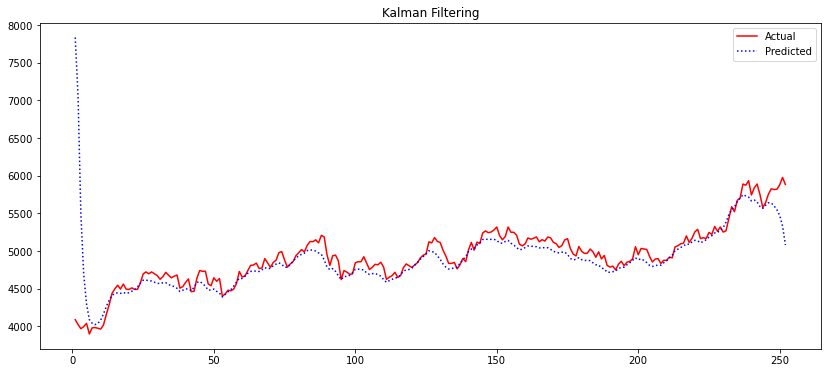

In [49]:
Y = NVR['Open']
T = Y.shape[0]
mu = 1196;


param0 = np.array([0.3, 0.9, 0.8, 1.1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T,T)


fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, u,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering")
plt.show()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1


/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60243/3475895941.py:7: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})


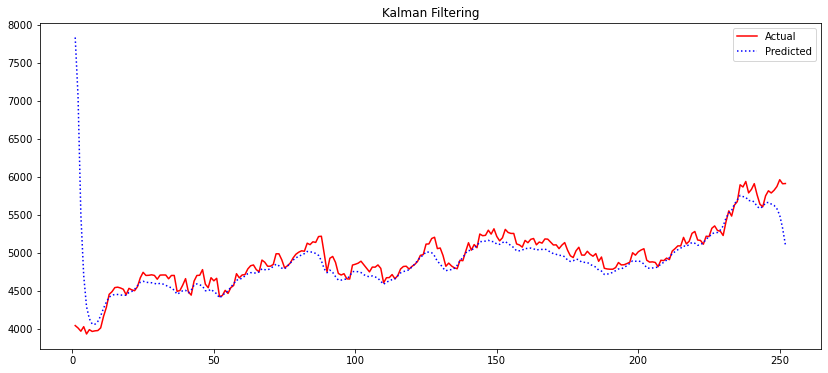

In [50]:
Y = NVR['Close']
T = Y.shape[0]
mu = 1196;


param0 = np.array([0.3, 0.9, 0.8, 1.1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T,T)


fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, u,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering")
plt.show()

In [51]:
results = pd.DataFrame({'Actual': list(Y),
                  'Predicted' : list(u),
                  'Date':NVR['Date'],
                  'Open':NVR['Open'],
                  'Close':NVR['Close']
                       })

In [52]:
results.set_index('Date',inplace = True)
results.head(10)

,Actual,Predicted,Open,Close
Date,,,,
2021-01-04,4040.649902,7830.145286,4089.979980,4040.649902
2021-01-05,4008.909912,7056.700935,4025.199951,4008.909912
2021-01-06,3966.489990,5494.543708,3970.000000,3966.489990
2021-01-07,4025.929932,4699.398041,3997.479980,4025.929932
2021-01-08,3930.000000,4290.081007,4040.689941,3930.000000
2021-01-11,3986.870117,4130.432123,3900.000000,3986.870117
2021-01-12,3963.189941,4060.047483,3982.010010,3963.189941
2021-01-13,3971.399902,4058.569499,3985.000000,3971.399902
2021-01-14,3975.050049,4095.314246,3976.000000,3975.050049


In [53]:
dif = pd.DataFrame({'Actual':list(Y),
                     'Predicted':list(u)})

In [54]:
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results)):
    if results['Predicted'][i] > results['Actual'][i-1]:
        action.append('Buy at Open')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Buy at Open',round(portfolio,2),stocks,round(balance,2))
        
        
        action.append('Sell at End')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Sell at Close',round(amount,2),balance)
        Amount.append(amount)
        
    else:
        action.append('Sell at Open')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Sell at Open',round(portfolio,2),'-',stocks,round(balance,2))
        
        
        action.append('Buy at Close')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Buy Back at Close',round(amount,2),balance)
        Amount.append(amount)
    print('\n')
        

0 Buy at Open 8179.96 2 1918
0 Sell at Close 9999.3 0


1 Buy at Open 8050.4 2 1981
1 Sell at Close 9998.82 0


2 Buy at Open 7940.0 2 2065
2 Sell at Close 9997.98 0


3 Buy at Open 7994.96 2 1946
3 Sell at Close 9997.86 0


4 Buy at Open 8081.38 2 2137
4 Sell at Close 9997.0 0


5 Buy at Open 7800.0 2 2023
5 Sell at Close 9996.74 0


6 Buy at Open 7964.02 2 2070
6 Sell at Close 9996.38 0


7 Buy at Open 7970.0 2 2053
7 Sell at Close 9995.8 0


8 Buy at Open 7952.0 2 2045
8 Sell at Close 9995.1 0


9 Buy at Open 7929.3 2 1975
9 Sell at Close 9994.9 0


10 Buy at Open 8042.0 2 1674
10 Sell at Close 9994.0 0


11 Buy at Open 8320.0 2 1436
11 Sell at Close 9993.64 0


12 Buy at Open 8575.46 2 1090
12 Sell at Close 9993.0 0


13 Sell at Open 8874.0 - 2 1021
13 Buy Back at Close 9992.82 0


14 Sell at Open 8998.0 - 2 912
14 Buy Back at Close 9992.0 0


15 Sell at Open 9094.94 - 2 900
15 Buy Back at Close 9991.44 0


16 Sell at Open 8992.22 - 2 921
16 Buy Back at Close 9991.0 0


17 Sell at 

176 Sell at Open 14883.0 - 3 415
176 Buy Back at Close 15221.14 0


177 Sell at Open 14808.09 - 3 149
177 Buy Back at Close 15221.0 0


178 Sell at Open 15182.94 - 3 8
178 Buy Back at Close 15220.22 0


179 Sell at Open 14994.0 - 3 315
179 Buy Back at Close 15219.45 0


180 Sell at Open 14906.34 - 3 319
180 Buy Back at Close 15219.16 0


181 Sell at Open 14916.6 - 3 166
181 Buy Back at Close 15218.35 0


182 Sell at Open 15082.35 - 3 286
182 Buy Back at Close 15218.02 0


183 Sell at Open 14969.34 - 3 359
183 Buy Back at Close 15217.88 0


184 Sell at Open 14756.76 - 3 255
184 Buy Back at Close 15216.93 0


185 Sell at Open 14969.97 - 3 559
185 Buy Back at Close 15216.88 0


186 Sell at Open 14687.55 - 3 390
186 Buy Back at Close 15216.75 0


187 Sell at Open 14826.96 - 3 834
187 Buy Back at Close 15216.24 0


188 Sell at Open 14430.0 - 3 860
188 Buy Back at Close 15215.99 0


189 Sell at Open 14365.23 - 3 870
189 Buy Back at Close 15215.58 0


190 Sell at Open 14400.0 - 3 870
190 Buy 

In [55]:
results['Amount'] = list(Amount)

In [56]:
results['Returns'] = results['Amount'].pct_change()

In [57]:
mean_returns = results['Returns'].mean()
sd = results['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(878)*(mean_returns)/sd
Sharpe_Ratio

0.0034401156191179176 0.06254869557203922


1.629678889843065

# A good model should have an RMSE value less than 180.


In [58]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(results['Actual'], results['Predicted']))
rms

348.13692082085794